# FA691 Homework 3
# Due: Wednesday, February 15 @ 11:59PM

Name: Ryan Shea

Date: 2023-02-02

In [11]:
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

# Set seed of random number generator
CWID = 10445281 #Place here your Campus wide ID number, this will personalize
#your results, but still maintain the reproduceable nature of using seeds.
#If you ever need to reset the seed in this assignment, use this as your seed
#Papers that use -1 as this CWID variable will earn 0's so make sure you change
#this value before you submit your work.
personal = CWID % 10000
np.random.seed(personal)

## Question 1 (10pt)

### Question 1.1
Use the `yfinance` package (or other method of your choice) to obtain the daily adjusted close prices for `SPY` and `IEF`.  You should have at least 5 years of data for both assets. Do **not** include any data after January 1, 2022.  You should inspect the dates for your data to make sure you are including everything appropriately.  Create a binary variable whether the `SPY` returns are above the `IEF` returns on a each day. Create a data frame (or array) of the daily log returns both both stocks along with the lagged returns (at least 2 lags) and your binary class variable.  Use the `print` command to display your data.

In [12]:
import datetime
tickers = ['SPY', 'IEF']
start = datetime.date.today() - datetime.timedelta(365*5+20) # 5 years, 20 days for buffer
yesterday = datetime.date.today() - datetime.timedelta(1)
data = yf.download(tickers=tickers, start=start, end=yesterday)['Adj Close']


df = data.apply(lambda x: np.log(x / x.shift(1)))

df['SPY_ABOVE_IEF'] = (df['SPY'] > df['IEF']).astype(int)

lags = 10

for t in tickers:
    for i in range(1, lags+1):
        df[f"{t}_{i}"] = df[t].shift(i)

df = df.dropna()

print(df.head(), end='\n\n')
print(f"{df.shape = }")


[*********************100%***********************]  2 of 2 completed
                 IEF       SPY  SPY_ABOVE_IEF     SPY_1     SPY_2     SPY_3  \
Date                                                                          
2018-01-31  0.000291  0.000497              1 -0.010310 -0.006652  0.011511   
2018-02-01 -0.005172 -0.001136              1  0.000497 -0.010310 -0.006652   
2018-02-02 -0.003711 -0.022010              0 -0.001136  0.000497 -0.010310   
2018-02-05  0.008184 -0.042722              0 -0.022010 -0.001136  0.000497   
2018-02-06 -0.004376  0.019511              1 -0.042722 -0.022010 -0.001136   

               SPY_4     SPY_5     SPY_6     SPY_7  ...     IEF_1     IEF_2  \
Date                                                ...                       
2018-01-31  0.000424 -0.000389  0.002120  0.008098  ... -0.002322 -0.002508   
2018-02-01  0.011511  0.000424 -0.000389  0.002120  ...  0.000291 -0.002322   
2018-02-02 -0.006652  0.011511  0.000424 -0.000389  ... -0.00

### Question 1.2
Split your data into training and testing sets (80% training and 20% test). This split should be done so that the causal relationship is kept consistent (i.e., split data at a specific time).

Run a logistic regression of the binary variable (of `SPY` returns greater than `IEF` returns) as a function of the lagged returns (at least 2 lags) for both stocks.
This should be of the form (assuming 2 lags) of $p_{t} = [1 + \exp(-[\beta_0 + \beta_{SPY,1} r_{SPY,t-1} + \beta_{SPY,2} r_{SPY,t-2} + \beta_{IEF,1} r_{IEF,t-1} + \beta_{IEF,2} r_{IEF,t-2}])]^{-1}$.
Evaluate the performance of this model by printing the confusion matrix and accuracy on the test data.

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score

temp = df.drop(["IEF", "SPY"], axis=1)

X_train, X_test, y_train, y_test = train_test_split(temp.drop("SPY_ABOVE_IEF", axis=1), temp['SPY_ABOVE_IEF'], test_size=0.2)

lr = LogisticRegression()
lr.fit(X_train, y_train)
l_pred = lr.predict(X_test)

print(f"Intercept: {float(lr.intercept_)}", end='\n\n')

for coef, name in zip(lr.coef_[0], X_train.columns):
    print(f" \u03B2 {name:>6}: {coef}")


print(confusion_matrix(y_test, l_pred))
print(f"Score: {accuracy_score(y_test, l_pred)}")



Intercept: 0.2093388159072138

 β  SPY_1: -0.33877434350234725
 β  SPY_2: 0.045685776888492985
 β  SPY_3: 0.016924869821582728
 β  SPY_4: -0.16493915343826604
 β  SPY_5: -0.144262347706821
 β  SPY_6: -0.1480369363175525
 β  SPY_7: 0.23453829384640992
 β  SPY_8: -0.2867485993735986
 β  SPY_9: 0.7024541374559272
 β SPY_10: -0.1580728284438531
 β  IEF_1: 0.020925767922942724
 β  IEF_2: -0.003655072909966451
 β  IEF_3: -0.020822794368135313
 β  IEF_4: 0.0442646149958374
 β  IEF_5: 0.1170858858512319
 β  IEF_6: 0.005792594266057701
 β  IEF_7: 0.038610141263482924
 β  IEF_8: 0.12067848805454327
 β  IEF_9: -0.26937391739996047
 β IEF_10: 0.05161213234420628
[[  0 122]
 [  0 130]]
Score: 0.5158730158730159


This is not a good model at all, as it is predicting True every single time. There is no real learning going on here, it just assumes that the SPY will always outperform IEF.

## Question 2 (30spt)

### Question 2.1
Using the same data, train/test split ratio, and consider the same classification problem as in Question 1.2.
Create a feed-forward neural network with a single hidden layer (10 hidden nodes) densely connected to the inputs.
You may choose any activation functions you wish.

In [14]:
from tensorflow import keras
from tensorflow.keras.layers import Dense
import tensorflow as tf

tf.random.set_seed(personal)

model = keras.Sequential()
model.add(Dense(10, input_shape=(X_train.shape[1],), activation='tanh'))
model.add(Dense(1, activation='sigmoid'))

model.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 10)                210       
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 11        
Total params: 221
Trainable params: 221
Non-trainable params: 0
_________________________________________________________________


### Question 2.2
Train this neural network on the training data.  
Evaluate the performance of this model by printing the confusion matrix and accuracy on the test data.

In [15]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=150, verbose=0, validation_split=0.1)

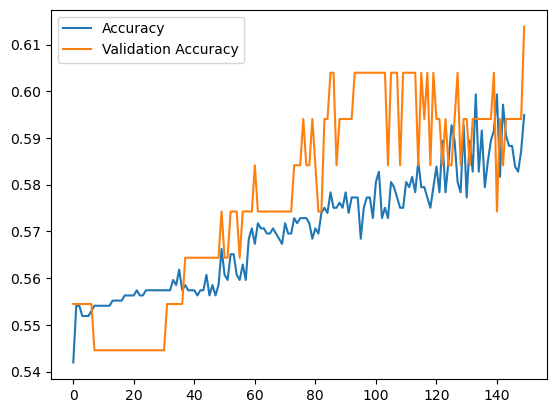



Train Accuracy: 0.5949227213859558
Validation Accuracy: 0.6138613820075989
Test Accuracy: 0.7131215929985046

[[31 91]
 [35 95]]
Score: 0.5


In [18]:
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()
print(f"\n\nTrain Accuracy: {history.history['accuracy'][-1]}")
print(f"Validation Accuracy: {history.history['val_accuracy'][-1]}")

print(f"Test Accuracy: {model.evaluate(X_test, y_test, verbose=0)[0]}", end='\n\n')

model_pred = (model.predict(X_test) > 0.5).astype(int)


def accuracy(confusion_matrix):
    return (confusion_matrix[0, 0] + confusion_matrix[1, 1]) / confusion_matrix.sum()

print(confusion_matrix(y_test, model_pred))
print(f"Score: {accuracy_score(y_test, model_pred)}")

The accuracy is significantly better than the logistic regression, as it is actually making a decision based off the data. It is not always predicting True anymore and is getting good test accuracy.

### Question 2.3
Using the same train/test split and consider the same classification problem as in Question 1.2.
Train and test another feed-forward neural network of your own design.

In [21]:
model2 = keras.Sequential()
model2.add(Dense(100, input_shape=(X_train.shape[1],), activation='tanh'))
model2.add(Dense(25, activation='relu'))
model2.add(Dense(10, activation='relu'))
model2.add(Dense(40, activation='relu'))
model2.add(Dense(1, activation='sigmoid'))

model2.summary()


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14 (Dense)             (None, 100)               2100      
_________________________________________________________________
dense_15 (Dense)             (None, 25)                2525      
_________________________________________________________________
dense_16 (Dense)             (None, 10)                260       
_________________________________________________________________
dense_17 (Dense)             (None, 40)                440       
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 41        
Total params: 5,366
Trainable params: 5,366
Non-trainable params: 0
_________________________________________________________________


In [22]:
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history2 = model2.fit(X_train, y_train, epochs=150, verbose=0, validation_split=0.1)

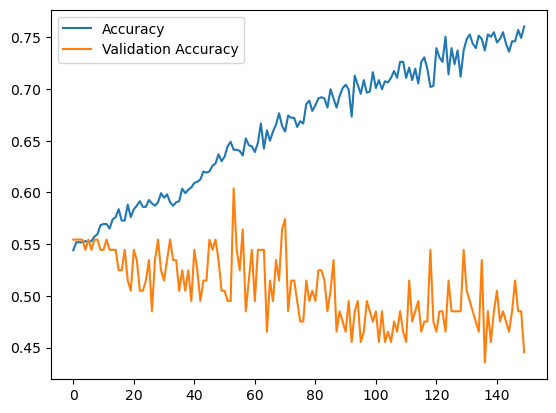



Train Accuracy: 0.7604856491088867
Validation Accuracy: 0.4455445408821106
Test Accuracy: 1.6103168725967407

[[45 77]
 [42 88]]
Score: 0.5277777777777778


In [23]:
plt.plot(history2.history['accuracy'], label='Accuracy')
plt.plot(history2.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()
print(f"\n\nTrain Accuracy: {history2.history['accuracy'][-1]}")
print(f"Validation Accuracy: {history2.history['val_accuracy'][-1]}")

print(f"Test Accuracy: {model2.evaluate(X_test, y_test, verbose=0)[0]}", end='\n\n')

model_pred = (model2.predict(X_test) > 0.5).astype(int)
print(confusion_matrix(y_test, model_pred))

matrix = confusion_matrix(y_test, model_pred)
print(f"Score: {accuracy(matrix)}")

## Question 3 (30pt)

### Question 3.1
Using the same data, train/test split ratio, and consider the same classification problem as in Question 1.2.
Create a time dilation neural network with a single convolutional layer (filter size of 10, kernel size of 2, dilation size of 1) densely connected to the inputs.
You may choose any activation functions you wish.

*Hint:* The CNN can reference earlier lags on its own without feeding explicit memory inputs as was needed for the Question 2.

In [7]:
# Enter your code here

### Question 3.2
Train this neural network on the training data.
Evaluate the performance of this model by printing the confusion matrix and accuracy on the test data.

In [8]:
# Enter your code here

<font color='red'>Solution:</font> 

### Question 3.3
Using the same train/test split and consider the same classification problem as in Question 1.2. Train and test another convolutional neural network of your own design.

In [9]:
# Enter your code here

<font color='red'>Solution:</font> 

## Question 4 (30pt)

## Question 4.1
Consider the same classification problem as in Question 1.2.
Of the methods considered in this assignment, which would you recommend in practice?
Explain briefly (1 paragraph) why you choose this fit. 

<font color='red'>Solution:</font> 

## Question 4.2
Recreate your data set using data from January 1, 2022 through December 31, 2022.
Using the method your would implement in practice, invest in the asset (``SPY`` or ``IEF``) depending on your predictions.
Print the returns your portfolio would obtain from following this strategy. Comment on how this portfolio compares with the ``SPY`` and ``IEF`` returns and risks.

In [10]:
# Enter your code here

<font color='red'>Solution:</font> 